##### Concurrency 2023/2024 - Computer Science
# Lecture 2 - Deutsch Algorithm

1. [Functions and libraries](#review)
2. [Deutsch's Algorithm](#Deutsch)
3. [Deutsch-Jozsa Algorithm](#Deutsch-jozsa)

### 1. Function and libraries

In [2]:
from qiskit import *
from qiskit.primitives import Sampler
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
import numpy as np

def execute_circuit(qc, shots=1024, binary=False, mode="sampler", reverse=False):
    
    if reverse:
        qc = qc.reverse_bits()
        
    if mode == "sampler":
    
        options = {"shots": shots}

        sampler = Sampler(options=options)
        
        job = sampler.run(qc)
        result = job.result()  
        
        probability_dictionary = result.quasi_dists[0]

        if binary:
            return probability_dictionary.binary_probabilities()
        else:
            return probability_dictionary
    
    else:
        #remember that for statevector measurements are not needed
        sv = Statevector.from_instruction(qc)
        return sv


## 2. Deutsch's algorithm <a id='deutsch'></a>

Let's consider a Boolean function $f:\{0,1\} \rightarrow \{0,1\}$ that can either be balanced or constant.

- **Constant**: its output is always 0 or always 1
- **Balanced**: outputs 0 for one input and 1 for the other


<p align="center">
  <img width="600" height="300" src="images/balanced_vs_constant.png">
</p>


<p align="center">
  <img width="600" height="200" src="images/deutsch.png">
</p>

$U_f$ is our function, usually seen as an oracle, or a black-box function that we want to find if it's balanced or constant

* If we have a **constant** function we measure the state $|0\rangle$ with certainty
* if we have **balanced** function we measure the state $|1\rangle$ with probability 1 !! 

##### why ? Let's go step by step

1) Initial state - $|00\rangle$
2) Create uniform superposition in the first qubit ------> $(H \otimes I) |00\rangle $
    $$ \frac{1}{\sqrt{2}}( |0\rangle + |1\rangle ) |0\rangle = \frac{1}{\sqrt{2}}( |00\rangle + |10\rangle)$$
3) Apply $x$ gate to the second qubit - $(I \otimes X) \frac{1}{\sqrt{2}}( |00\rangle + |10\rangle)$
   $$ \frac{1}{\sqrt{2}}( |01\rangle + |11\rangle) $$
4) Create uniform superposition in the second qubit (attention to the signs !) ----->  $(I \otimes H) \frac{1}{\sqrt{2}}( |01\rangle + |11\rangle) $
   
$$H = 
\frac{1}{\sqrt{2}}\begin{pmatrix}
1 & 1\\
1 & -1
\end{pmatrix}
$$

$$ \frac{1}{\sqrt{2}}( |0\rangle \frac{1}{\sqrt{2}}( |0\rangle - |1\rangle ) + |1\rangle \frac{1}{\sqrt{2}}( |0\rangle - |1\rangle )) = \frac{1}{2}(|00\rangle - |01\rangle + |10\rangle - |11\rangle)$$

5) Apply $U_f = I \otimes I$ ----> $(I \otimes I)(\frac{1}{2}(|00\rangle - |01\rangle + |10\rangle - |11\rangle))$

    $$ \frac{1}{2}(|00\rangle - |01\rangle + |10\rangle - |11\rangle))$$

6) Apply hadamard to the first qubit ----> $(H \otimes I) \frac{1}{2}(|00\rangle - |01\rangle + |10\rangle - |11\rangle))$

    $$\frac{1}{2}\left[\frac{1}{\sqrt{2}}( |0\rangle + |1\rangle ) |0\rangle - \frac{1}{\sqrt{2}}( |0\rangle + |1\rangle ) |1\rangle + \frac{1}{\sqrt{2}}( |0\rangle - |1\rangle ) |0\rangle - \frac{1}{\sqrt{2}}( |0\rangle - |1\rangle ) |1\rangle \right] $$

    $$\frac{1}{2\sqrt{2}}\left[|00\rangle + |10\rangle - |01\rangle -|11\rangle +|00\rangle -|10\rangle - |01\rangle + |11\rangle \right] $$

    $$\frac{1}{2\sqrt{2}} \left[2|00\rangle - 2|01\rangle \right]$$

Thus, we can see that by applying the hadamard in the first qubit after the function , we created interference, leaving only states with first qubit=0. We have a constant function. 

If we repeat the process for a balanced function, we will be measuring state $|1\rangle$ in the first qubit instead. 


##### <span style="color: red;">Exercise 1:</span> - Suppose the black-box function (1). Implement the full deutsch circuit. 

In [3]:
def U_f(n_qubits=1):

    qr_input = QuantumRegister(n_qubits, "input")
    qr_ancilla = QuantumRegister(1, "ancilla")

    qc = QuantumCircuit(qr_input, qr_ancilla)
    
    return qc


def deutsch(U_f=None, n_qubits=1):

    qr_input = QuantumRegister(n_qubits, "input")
    qr_ancilla = QuantumRegister(1, "ancilla")

    cr = ClassicalRegister(n_qubits, "measure")

    qc = QuantumCircuit(qr_input, qr_ancilla, cr)

    # first qubit
    qc.h(qr_input)

    #ancilla
    qc.x(qr_ancilla)
    qc.h(qr_ancilla)

    qc.barrier()

    #compose circuit with U_f
    qc = qc.compose(U_f)

    qc.barrier()

    #interference first qubit
    qc.h(qr_input)

    qc.barrier()

    #measure the first qubit 
    qc.measure(qr_input, cr)

    return qc

Create the deutsch circuit

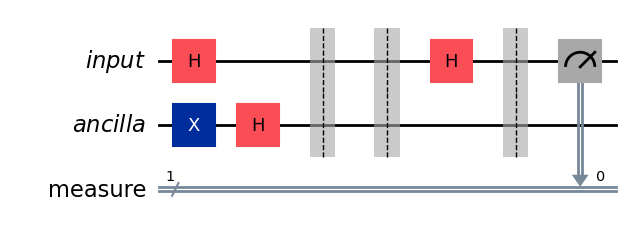

In [4]:
u_f = U_f()
qc = deutsch(U_f=u_f)
qc.draw(output="mpl")

Execute the circuit and see the result

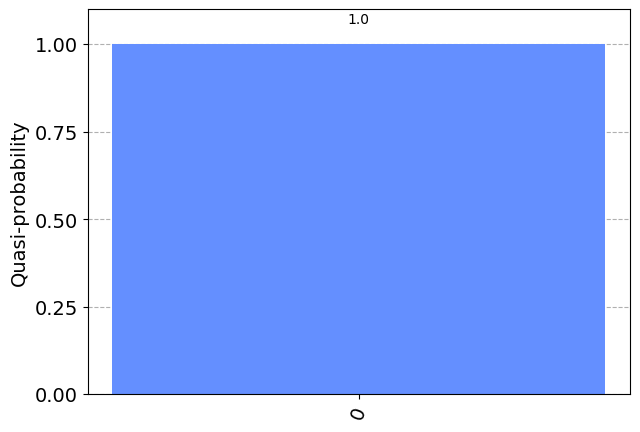

In [5]:
probs = execute_circuit(qc, shots=100000, binary=True, mode="sampler")
plot_histogram(probs)

##### <span style="color: red;">Exercise 2:</span> - Modify the oracle to support every balanced/constant function. 

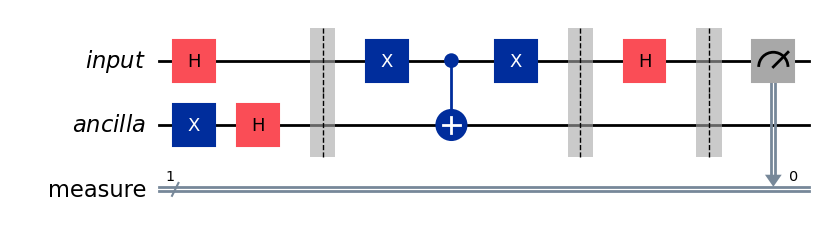

In [8]:
def U_f(n_qubits=1, function="1"):

    qr_input = QuantumRegister(n_qubits, "input")
    qr_ancilla = QuantumRegister(1, "ancilla")

    qc = QuantumCircuit(qr_input, qr_ancilla)

    if function == "2":
        qc.x(qr_ancilla)
    elif function == "3":
        qc.cx(qr_input[0], qr_ancilla)
    elif function == "4":
        qc.x(qr_input)
        qc.cx(qr_input[0], qr_ancilla)
        qc.x(qr_input)

    return qc   

u_f = U_f(n_qubits=1, function="4")

qc = deutsch(U_f=u_f)
qc.draw(output="mpl")

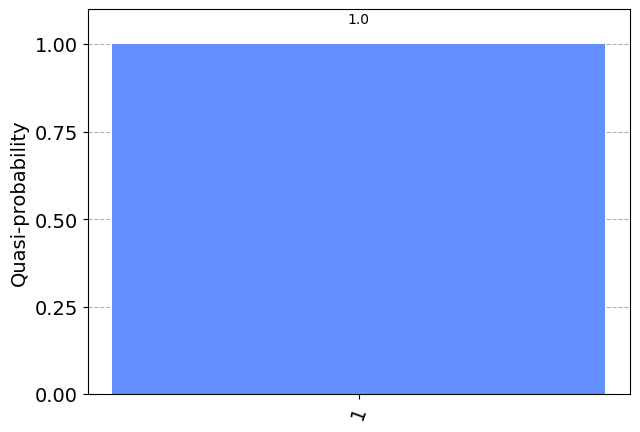

In [6]:
probs = execute_circuit(qc, shots=1000, binary=True, mode="sampler")
plot_histogram(probs)

## 4. Deutsch-Jozsa algorithm <a id='deutsch-josza'></a>

Deutsch-Josza algorithm is the generalization of the previous algorithm for boolean functions for $n$ bit strings rather than single bit string inputs.

<p align="center">
  <img width="700" height="200" src="images/dj.png">
</p>

The results for the single input case also remain true in this setting with minor differences:

* Hadamard uniform superposition over all qubits instead of a single qubit
* We will measure all input qubits instead of the single qubit
* $P(000 \dots 0)=0$ if the function is **constant**
* $P(111 \dots 1)=1$ if the function is **balanced**


##### <span style="color: red;">Exercise 3:</span> - write the Deutsch-Josza algorithm

In [7]:
def deutsch_jozsa(U_f=None, n_qubits=2):

    cr =
    qr = 
    ancilla = 
    qc =

    # qubits input

    #ancilla

    qc.barrier()
    
    #compose circuit with U_f

    qc.barrier()
    
    #interference input qubits

    #measure the input qubits 

    return qc

SyntaxError: invalid syntax (4197482601.py, line 3)

##### <span style="color: red;">Exercise 4:</span> - Consider the following 3-qubit input state truth table:

| Input | Output |
|-------|--------|
| 000   | 1      |
| 001   | 1      |
| 010   | 1      |
| 011   | 1      |
| 100   | 0      |
| 101   | 0      |
| 110   | 0      |
| 111   | 0      |

How may we implement the function? 

In [ ]:
def U_f(n_qubits=2):

    #qc = 

    return qc

In [ ]:
#execute_circuit

##### <span style="color: red;">Exercise 5:</span> - Implement a quantum circuit that performs the XOR function

Truth table for the XOr logic gate
|x_0|x_1|x_2|        
|-|-|-|
|0|0|0|
|0|1|1|
|1|0|1|
|1|1|0|

In [ ]:
def xor_function(n_qubits=3):

    qc = QuantumCircuit(n_qubits)

    #state |10>


    #state |01>

    return qc

In [ ]:
xor = xor_function()
xor.draw(output="mpl")

Suppose a **classical** algorithm that finds if the function is actually balanced or constant. The algorithm has to run through all the four possible combinations. In average the algorithm has to run through half the combinations in order to discover if the function is balanced .

In general, if we have $n$ bit string , we have to check $\frac{2^n}{2} + 1$. 

The quantum algorithm from Deutsch promises to find if the function is balanced or constant in a single step! 

But how ? We have seen that simply acting in superposition does not solve the problem because we will need to run the quantum circuit several times do the stochastic nature! 

The novel trick of the algorithm is actually collapse the superposition into a deterministic state of interest using INTERFERENCE ! Not possible in classical computing !

##### <span style="color: red;">Exercise 6:</span> - Consider the following function:

$$f(x) = \begin{cases} 1 & \text{if } x=11111 \\ 0 & \text{otherwise} \end{cases}$$



In [ ]:
def mcx(n_qubits=5):

    qr = 
    ancilla = 
    cr = 
    qc = 

    return qc

In [ ]:
uf = mcx()
uf.draw(output="mpl")

In [ ]:
qc = deutsch_jozsa(U_f=uf,n_qubits=5)

probs = execute_circuit(qc, shots=10000, binary=True, mode="sampler")
plot_histogram(probs)